# About Notebook
This is a notebook designed to train the plant disease dataset found on Kaggle, [here](https://www.kaggle.com/vipoooool/new-plant-diseases-dataset). I made this notebook to have a built network to train plant diseases. With little understanding of Keras, the notebook should be easly to re-use by users. To use this notebook, I seperated the plant dataset into different plants and they were trained seperately.

# Import necessery libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import pandas as pd
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load filepath and set constant image size

In [ ]:
IMAGE_SIZE = [224, 224]

base_dir = '/content/drive/My Drive/datasets/Plants/cassava'
train_path = base_dir + '/train'
validation_path = base_dir + '/valid'

folders = glob(train_path + '/*')
folders

['/content/drive/My Drive/datasets/Plants/cassava/train/cgm',
 '/content/drive/My Drive/datasets/Plants/cassava/train/cmd',
 '/content/drive/My Drive/datasets/Plants/cassava/train/healthy',
 '/content/drive/My Drive/datasets/Plants/cassava/train/cbb',
 '/content/drive/My Drive/datasets/Plants/cassava/train/cbsd']

# Observe the data in the dataset
It is important to observe how th data is distributed across all categories. This is to know if you are working with balanced or imbalanced dataset

In [ ]:
def observe_data(fpath):
  import os
  import pandas as pd
  import matplotlib.pyplot as plt

  data = {}

  plant_classes = [x[0] for x in os.walk(fpath) ]
  for fpath in plant_classes[1:]:
    items = os.listdir(fpath)
    
    data[fpath.split('/')[-1]] = len(items)
    
  df = pd.DataFrame(list(data.items() ), columns=['class', 'number of images'])

  plt.bar(df['class'], df['number of images'], color='rgbkymc')
  for index, value in enumerate(df['number of images']):
      s = '{}'.format(value)
      plt.text(index,value , str(s), fontsize=8)
  plt.xticks(rotation=90)
  plt.show()
  return df


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  app.launch_new_instance()


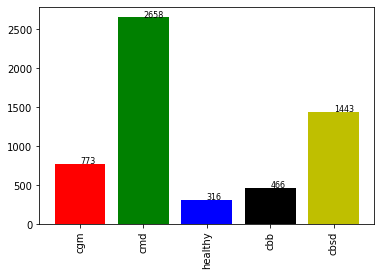

In [ ]:
df = observe_data(train_path)

# Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earlystopping = EarlyStopping(              # interrupts training when improvement stops
                  monitor='val_accuracy',   # Monitors the model’s validation accuracy
                  patience=6 )              # Interrupt when model doesn't increase after 6 steps


checkpoint =  ModelCheckpoint(                           # Saves the current weights after every epoch
                  filepath=base_dir + '/my_model_checkpoint.h5',     # Path to the destination model file

                  # These two arguments mean you won’t overwrite the
                  # model file unless val_loss has improved, which allows
                  # you to keep the best model seen during training.
                  monitor='val_loss',
                  save_best_only=True )


# Processing input

In [ ]:
def process_input(train_path, validation_path):
  train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

  # Validation set should not be argumented
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
                train_path,                  # target directory
                target_size=IMAGE_SIZE,      # resize image to 224 x 224
                batch_size=20,
                class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
                  validation_path,
                  target_size=IMAGE_SIZE,
                  batch_size=20,
                  class_mode='categorical')
  
  return train_generator, validation_generator

# Using a pretrained network to build the model
## Instantiating the inception V3 convolutional base

In [ ]:
def model_def(folders):
  inception_conv_base = InceptionV3(input_shape= IMAGE_SIZE + [3],
                        weights='imagenet',
                        include_top=False)
  
  model = Sequential()
  model.add( inception_conv_base )
  model.add( Flatten() )
  model.add( Dense(len(folders), activation='softmax') )

  model.compile( loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  return model

# Train Model

In [ ]:
from time import time

start = time()

model = model_def(folders)
train_generator, validation_generator = process_input(train_path, validation_path)

history = model.fit_generator(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            steps_per_epoch=len(train_generator),
            validation_steps=len(validation_generator),
            callbacks=[earlystopping, checkpoint])

# save model
model.save(base_dir + '/maize_inception_v3.h5')
print('\n\nDuration: {} seconds'.format(time() - start))

87916544/87910968 [==============================] - 1s 0us/step
Found 7316 images belonging to 4 classes.
Found 1829 images belonging to 4 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
366/366 [==============================] - 2187s 6s/step - loss: 0.7837 - accuracy: 0.8324 - val_loss: 1.4413 - val_accuracy: 0.8425
Epoch 2/20
366/366 [==============================] - 128s 349ms/step - loss: 0.2450 - accuracy: 0.9237 - val_loss: 0.1204 - val_accuracy: 0.9710
Epoch 3/20
366/366 [==============================] - 125s 343ms/step - loss: 0.4051 - accuracy: 0.8949 - val_loss: 52.0264 - val_accuracy: 0.7862
Epoch 4/20
366/366 [==============================] - 132s 361ms/step - loss: 0.2576 - accuracy: 0.9256 - val_loss: 0.1042 - val_accuracy: 0.9617
Epoch 5/20
366/366 [==============================] - 126s 344ms/step - loss: 0.1913 - accuracy: 0.9434 - val_loss: 0.1316 - val_accuracy: 0.9508
Epoch 6/20
366/366 [==========================

In [ ]:
test_loss, test_acc = model.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)


Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.925000011920929


In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

IMAGE_SIZE = [224, 224]
filepath = base_dir + '/my_model_checkpoint.h5'

model_2 = load_model(
    filepath,
    custom_objects=None,
    compile=True)

test_loss, test_acc = model_2.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.9629999995231628


# Plot

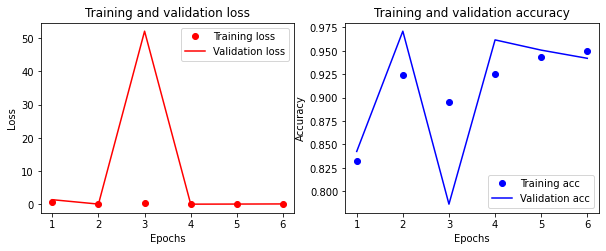

In [ ]:
def plot_history(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    history_dict = history.history
    df = pd.DataFrame(history_dict)

    plt.rcParams['figure.figsize'] = [10, 3.5]
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    p1, p2 = axs[0], axs[1]

    epochs = range(1, len(df.index) + 1)
    p1.plot(epochs, df[df.columns[0]], 'ro', label='Training loss')
    p1.plot(epochs, df[df.columns[2]], 'r', label='Validation loss')
    p1.set_title('Training and validation loss')
    p1.set_xlabel('Epochs')
    p1.set_ylabel('Loss')
    p1.legend()

    p2.plot(epochs, df[df.columns[1]], 'bo', label='Training acc')
    p2.plot(epochs, df[df.columns[3]], 'b', label='Validation acc')
    p2.set_title('Training and validation accuracy')
    p2.set_xlabel('Epochs')
    p2.set_ylabel('Accuracy')
    p2.legend()

    plt.show()

plot_history(history)